In [2]:
import os
from matplotlib import pyplot as plt
import numpy as np
import time as tm
import warnings

In [3]:
folder_name = 'Data Input'
path = f'/Users/ricoxi/Desktop/Coding/Fresnel Factor/{folder_name}'

In [4]:
os.chdir(path)
print('Working path changed to \n' + os.getcwd())

Working path changed to 
/Users/ricoxi/Desktop/Coding/Fresnel Factor/Data Input


In [5]:
files = os.listdir()
data_files = []
for i in files:
    if '.txt' in i:
        data_files.append(i)
print('Working data files: \n')
for i in data_files:
    print('\t'+i)

Working data files: 

	Au_new.txt
	sapphire_optical.txt
	d2o_optical.txt
	gold.txt
	gold_optical.txt
	water_optical.txt
	h2o_1973.txt


In [6]:
def to_wn(value):
    wn = 10 ** 7 / value
    return wn

def to_wl(value):
    wl = 10 ** 7 / value
    return wl

In [7]:
# Appending water optical constants...

wn_water = []
# this is n
n_water = []
# this is k
k_water = []

with open('water_optical.txt', 'r') as f:
    for line in f.readlines()[1:]:
        field = line.split(' ')
        wn_water.append(float(field[0]))
        wn_water.append(float(field[5]))
        n_water.append(float(field[2]))
        n_water.append(float(field[7]))
        k_water.append(float(field[1]))
        k_water.append(float(field[6]))

# this is a list tuple containing wavenumbers 
# and their corresponding n,k values
water = [(wn_water[i],n_water[i],k_water[i]) for i in np.arange(len(wn_water))]
water.sort(key = lambda x: x[0])
print('Water optical constants are appended in the list "water".')

# Appending sapphire optical constants...

wl_um = []
n_sapphire = []
with open('sapphire_optical.txt') as f:
    for line in f.readlines():
        field = line.split('\t')
        wl_um.append(float(field[0]))
        n_sapphire.append(float(field[1]))

wl_nm = [i * 1000 for i in wl_um]
wn_sapphire = [to_wn(i) for i in wl_nm]
# This is a list tuple containing sapphire's optical constants
sapphire = [(wn_sapphire[i], n_sapphire[i]) for i in np.arange(len(wn_sapphire))]
sapphire.sort(key = lambda x: x[0])
print('Sapphire optical constants are appended in the list "sapphire".')

# Appending gold optical constants...

wl_um = []
n_gold = []
k_gold = []
with open('gold_optical.txt') as f:
    for line in f.readlines():
        field = line.split('\t')
        wl_um.append(float(field[0]))
        n_gold.append(float(field[1]))
        k_gold.append(float(field[2]))

wl_nm = [i * 1000 for i in wl_um]
wn_gold = [to_wn(i) for i in wl_nm]
gold = [(wn_gold[i],n_gold[i],k_gold[i]) for i in np.arange(len(wn_gold))]
gold.sort(key = lambda x: x[0])
print('Gold optical constants are appended in the list "gold".')

Water optical constants are appended in the list "water".
Sapphire optical constants are appended in the list "sapphire".
Gold optical constants are appended in the list "gold".


In [8]:
'''
selecting data from 2000 to 4000 cm-1
'''

def wn_select(data, lo, hi):
    pts = []
    for i in np.arange(len(data)):
        if lo <= data[i][0] <= hi:
            if len(data[i]) >= 3:
                pt = (data[i][0],data[i][1],data[i][2])
            else:
                pt = (data[i][0],data[i][1],0)
            pts.append(pt)
    return pts

In [9]:
lo = 2400.
hi = 4000.
water_new = wn_select(water, lo, hi)
sapphire_new = wn_select(sapphire, lo, hi)
gold_new = wn_select(gold, lo, hi)

In [10]:
# binning data to find common x-axis
def mybin(data, wn_bound1, wn_bound2, step):

    warnings.filterwarnings("ignore", 'Mean of empty slice.')
    warnings.filterwarnings("ignore", 'invalid value encountered in double_scalar')
    
    X = [i[0] for i in data]
    bins = np.linspace(wn_bound1, wn_bound2, step)
    digitized = np.digitize(X, bins)-1
    bin_centers = bins + (bins[1]-bins[0])/2

    Y = [i[1] for i in data]
    Y = np.asarray(Y, dtype='float')
    bin_medians = [np.median(Y[digitized == j]) for j in range(len(bins))]
    
    new = [(bin_centers[i],bin_medians[i]) for i in range(len(bins))]
    return new

In [11]:
# curve_fitting to find common x_axis
'''
IMPORTANT: 

This is just a simple polynomial fit for well-behaved materials
within the selected wavenumber range. One may need a better fit
if the features are more complex in the desired frequency range.

'''
def fit_curve(data, zone, degree):
    wn = [i[0] for i in data]
    n  = [i[1] for i in data]
    k  = [i[2] for i in data]

    wn_n = np.polyfit(wn, n, degree)
    wn_k = np.polyfit(wn, k, degree)
    f_n  = np.poly1d(wn_n)
    f_k  = np.poly1d(wn_k)

    wn_new = zone
    n_new  = f_n(wn_new)
    k_new  = f_k(wn_new)

    plt.subplot(1, 2, 1)
    plt.plot(wn, n, 'o', wn_new, n_new)
    plt.title('wn vs n')
    plt.subplot(1, 2, 2)
    plt.plot(wn, k, 'o', wn_new, k_new)
    plt.title('wn vs k')

    new = [(wn_new[i], n_new[i], k_new[i]) for i in range(len(wn_new))]

    return new

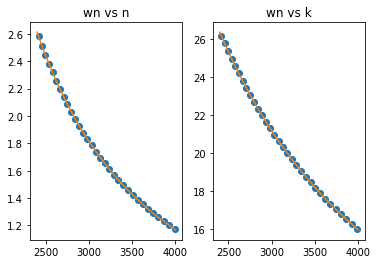

In [12]:
ir_zone = [i[0] for i in water_new]
gold_fitted_ir = fit_curve(gold_new, ir_zone, 10)

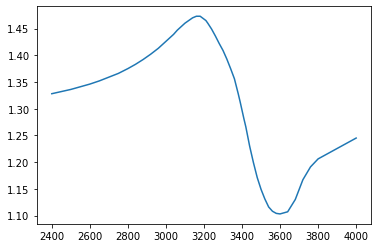

In [15]:
plt.plot([i[0] for i in water_new],[i[1] for i in water_new])

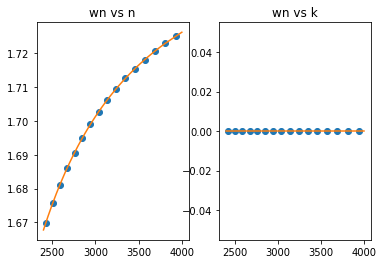

In [176]:
sapphire_fitted_ir = fit_curve(sapphire_new, ir_zone, 10)

(0, 50000)

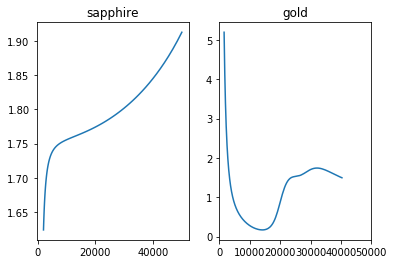

In [177]:
plt.subplot(1, 2, 1)
plt.plot([i[0] for i in sapphire], [i[1] for i in sapphire])
plt.title('sapphire')
plt.subplot(1, 2, 2)
plt.plot([i[0] for i in gold], [i[1] for i in gold])
plt.title('gold')
plt.xlim(0, 50000)

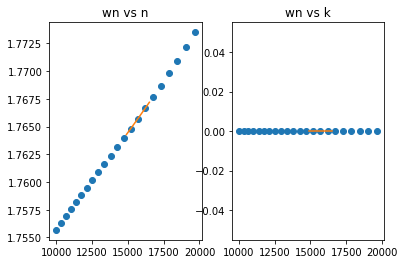

In [167]:
sfg_lo = 10000
sfg_hi = 20000
sapphire_sfg = wn_select(sapphire, sfg_lo, sfg_hi)

vis_wl = 800
sfg_zone = [i[0] + to_wn(vis_wl) for i in water_new]
sapphire_fitted_sfg = fit_curve(sapphire_sfg, sfg_zone, 10)

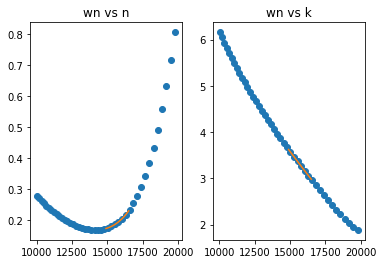

In [146]:
sfg_lo = 10000
sfg_hi = 20000
gold_sfg = wn_select(gold, sfg_lo, sfg_hi)

vis_wl = 800
sfg_zone = [i[0] + to_wn(vis_wl) for i in water_new]
gold_fitted_sfg = fit_curve(gold_sfg, sfg_zone, 10)

In [147]:
sapphire_vis = (12500.0, 1.7601, 0)
gold_vis = (12500.0, 0.1885769968431532, 4.705410395614308)
water_vis = (12500.0, 1.3290, 0)

water_sfg = gold_fitted_sfg
water_sfg = [(i[0], 1.33, 0) for i in water_sfg]

In [148]:
m1 = (sapphire_fitted_ir, sapphire_vis, sapphire_fitted_sfg)
m2 = (gold_fitted_ir, gold_vis, gold_fitted_sfg)
m3 = (water_new, water_vis, water_sfg)

In [149]:
class opt_cst_lib():
    def __init__(self, m1, m2, m3):
        self.m1_ir = m1[0]
        self.m2_ir = m2[0]
        self.m3_ir = m3[0]
        self.m1_vis = m1[1]
        self.m2_vis = m2[1]
        self.m3_vis = m3[1]
        self.m1_sfg = m1[2]
        self.m2_sfg = m2[2]
        self.m3_sfg = m3[2]

In [150]:
mylib = opt_cst_lib(m1, m2, m3)